# NLP Sentiment Analysis - Tensorflow Hub modules IMDB

#### Prepared by Jocelyn Prince (2019/12)
---

## Sentiment Analysis Project - Post to Medium
#### NLP with the following Modules from Tensorflow Hub
* nnlm-en-dim128
* Universal Sentence Encoder


### Description
Use some modules available in Tensorflow Hub to experiment NLP tasks.  Deploy a model on Google's AI-Platform (also called ML Engine) and demonstrate the model returning a prediction.

Details:
* Dataset for training: IMDB

References:

* Prateek Joshi and his post: https://www.analyticsvidhya.com/blog/2019/03/learn-to-use-elmo-to-extract-features-from-text/

* https://arxiv.org/pdf/1802.05365.pdf

* https://colab.research.google.com/github/tensorflow/hub/blob/master/examples/colab/tf2_text_classification.ipynb#scrollTo=Eg62Pmz3o83v

* Aurélien Géron’s Book: hands-on Machine Learning with Scikit-Learn, Keras and Tensorflow, O’Reilly Media Inc.

* https://colab.research.google.com/github/tensorflow/hub/blob/master/docs/tutorials/text_classification_with_tf_hub.ipynb#scrollTo=23U30yEkVq4w
-----

In [1]:
import tensorflow as tf
assert tf.__version__ >= "2.0"

AssertionError: ignored

In [2]:
!pip install --upgrade tensorflow

     |████████████████████████████████| 86.3MB 51kB/s 
     |████████████████████████████████| 3.8MB 39.9MB/s 
     |████████████████████████████████| 450kB 44.4MB/s 
     |████████████████████████████████| 81kB 9.8MB/s 
ERROR: tensorboard 2.0.2 has requirement grpcio>=1.24.3, but you'll have grpcio 1.15.0 which is incompatible.
ERROR: google-colab 1.0.0 has requirement google-auth~=1.4.0, but you'll have google-auth 1.10.0 which is incompatible.
  Found existing installation: google-auth 1.4.2
    Uninstalling google-auth-1.4.2:
      Successfully uninstalled google-auth-1.4.2
  Found existing installation: tensorboard 1.15.0
    Uninstalling tensorboard-1.15.0:
      Successfully uninstalled tensorboard-1.15.0
  Found existing installation: tensorflow-estimator 1.15.1
    Uninstalling tensorflow-estimator-1.15.1:
      Successfully uninstalled tensorflow-estimator-1.15.1
  Found existing installation: tensorflow 1.15.0
    Uninstalling tensorflow-1.15.0:
      Successfully uninstalle

In [3]:
!pip install --upgrade scikit-learn

     |████████████████████████████████| 7.1MB 6.2MB/s 
  Found existing installation: scikit-learn 0.21.3
    Uninstalling scikit-learn-0.21.3:
      Successfully uninstalled scikit-learn-0.21.3


In [4]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


# Import Libraries

In [1]:
# This Notebook needs to be executed under Python ≥3.5 and TensorFlow >= 2.0
import sys
assert sys.version_info >= (3, 5)
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras import optimizers
import tensorflow_hub as hub
assert tf.__version__ >= "2.0"

# Minimum Requirement for Scikit-Learn ≥0.20 is required
import sklearn
assert sklearn.__version__ >= "0.20"

try:
    # %tensorflow_version only exists in Colab.
    %tensorflow_version 2.x
    !pip install -q -U tensorflow-addons
    IS_COLAB = True
except Exception:
    IS_COLAB = False

if not tf.test.is_gpu_available():
    print("No GPU was detected. This code can be very slow without a GPU.")
    if IS_COLAB:
        print("Go to Runtime > Change runtime and select a GPU hardware accelerator.")

# Common imports
import time
import pandas as pd
import numpy as np
import os

# to make this notebook's output stable across runs
np.random.seed(20)
tf.random.set_seed(20)



TensorFlow is already loaded. Please restart the runtime to change versions.


In [0]:
# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
# mpl.rc('axes', labelsize=14)
# mpl.rc('xtick', labelsize=12)
# mpl.rc('ytick', labelsize=12)
# mpl.rcParams['figure.figsize'] = (8, 6)
# mpl.rcParams['axes.grid'] = False

# Where to save the figures
PROJECT_ROOT_DIR = "."
FOLDER= "rnn"
IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, "images", FOLDER)
os.makedirs(IMAGES_PATH, exist_ok=True)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = os.path.join(IMAGES_PATH, fig_id + "." + fig_extension)
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

In [0]:
import tensorflow_datasets as tfds
from tensorflow.keras import optimizers

In [4]:
tf.__version__

'2.0.0'

In [5]:
import tensorflow as tf
tf.test.is_gpu_available()

True

In [6]:
# The spacy module needs to be installed
!pip install spacy

# The english module needs to be downloaded if not already
!python3 -m spacy download en

✔ Download and installation successful
You can now load the model via spacy.load('en_core_web_sm')
✔ Linking successful
/usr/local/lib/python3.6/dist-packages/en_core_web_sm -->
/usr/local/lib/python3.6/dist-packages/spacy/data/en
You can now load the model via spacy.load('en')


In [0]:
# Import other common libraries
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score 
import itertools
import re
import spacy

# Import Dataset: iMDB Movie Reviews


In [8]:
train_data, test_data = tfds.load(name="imdb_reviews", split=["train", "test"], 
                                  batch_size=-1, as_supervised=True)

train_examples, y_train = tfds.as_numpy(train_data)
test_examples, y_test = tfds.as_numpy(test_data)

Instructions for updating:
Use eager execution and: 
`tf.data.TFRecordDataset(path)`


Instructions for updating:
Use eager execution and: 
`tf.data.TFRecordDataset(path)`


Dataset imdb_reviews downloaded and prepared to /root/tensorflow_datasets/imdb_reviews/plain_text/0.1.0. Subsequent calls will reuse this data.


In [9]:
print("Training entries: {}, test entries: {}".format(len(train_examples), len(test_examples)))

Training entries: 25000, test entries: 25000


In [10]:
train_examples[:10]

array([b"As a lifelong fan of Dickens, I have invariably been disappointed by adaptations of his novels.<br /><br />Although his works presented an extremely accurate re-telling of human life at every level in Victorian Britain, throughout them all was a pervasive thread of humour that could be both playful or sarcastic as the narrative dictated. In a way, he was a literary caricaturist and cartoonist. He could be serious and hilarious in the same sentence. He pricked pride, lampooned arrogance, celebrated modesty, and empathised with loneliness and poverty. It may be a clich\xc3\xa9, but he was a people's writer.<br /><br />And it is the comedy that is so often missing from his interpretations. At the time of writing, Oliver Twist is being dramatised in serial form on BBC television. All of the misery and cruelty is their, but non of the humour, irony, and savage lampoonery. The result is just a dark, dismal experience: the story penned by a journalist rather than a novelist. It's not

In [11]:
y_train[:10]

array([1, 1, 1, 1, 1, 1, 0, 1, 1, 0])

In [0]:
X_train = pd.DataFrame(train_examples, columns=["tweet"])
X_test = pd.DataFrame(test_examples, columns=["tweet"])

In [0]:
X_train["tweet"] = X_train["tweet"].apply(lambda x: x.decode("utf-8"))
X_test["tweet"] = X_test["tweet"].apply(lambda x: x.decode("utf-8"))

# Data Preprocessing

## Explore Data

In [14]:
X_train.describe()

,tweet
count,25000
unique,24904
top,"When i got this movie free from my job, along ..."
freq,3


In [15]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25000 entries, 0 to 24999
Data columns (total 1 columns):
tweet    25000 non-null object
dtypes: object(1)
memory usage: 195.4+ KB


In [16]:
X_train.head()

,tweet
0,"As a lifelong fan of Dickens, I have invariabl..."
1,Oh yeah! Jenna Jameson did it again! Yeah Baby...
2,I saw this film on True Movies (which automati...
3,This was a wonderfully clever and entertaining...
4,I have no idea what the other reviewer is talk...


In [17]:
print("X_train: " + str(X_train.shape) + str(type(X_train)))
print("y_train: "+ str(y_train.shape)+ str(type(y_train)))
print("X_test: " + str(X_test.shape) + str(type(X_test)))
print("y_test: "+ str(y_test.shape)+ str(type(y_test)))

X_train: (25000, 1)<class 'pandas.core.frame.DataFrame'>
y_train: (25000,)<class 'numpy.ndarray'>
X_test: (25000, 1)<class 'pandas.core.frame.DataFrame'>
y_test: (25000,)<class 'numpy.ndarray'>


## Functions : Text-preprocessing and Lemmatize (Normalize) Tweets

In [0]:
def text_processing(tweet, preprocess=True):
    # remove https links
    clean_tweet = re.sub(r'http\S+', '', tweet)
    # remove punctuation marks
    punctuation = '!"#$%&()*+-/:;<=>?@[\\]^_`{|}~'
    clean_tweet = ''.join(ch for ch in clean_tweet if ch not in set(punctuation))
    # convert text to lowercase
    clean_tweet = clean_tweet.lower()
    # remove numbers
    clean_tweet = re.sub('\d', ' ', clean_tweet)
    # remove whitespaces
    clean_tweet = ' '.join(clean_tweet.split())
    #return clean_tweet
    if preprocess:
      return clean_tweet
    else:
      return tweet

In [0]:
# import the english language model from spacy'
nlp = spacy.load('en', disable=['parser', 'ner'])
#nlp = spacy.load('en')

# function to lemmatize text
def lemmatization(tweets):
    lemma_tweet = []
    for i in tweets:
        t = [token.lemma_ for token in nlp(i)]
        lemma_tweet.append(' '.join(t))
    return lemma_tweet

## Perform the data preprocessing

In [0]:
# nnlm-en-dim128 does the preprocessing itself, so we do not need to perform prerprocessing prior to the execution of the model
PREPROCESS = False

In [21]:
%%time
X_train['clean_tweet'] = X_train['tweet'].apply(lambda x: text_processing(x, PREPROCESS))
X_test['clean_tweet'] = X_test['tweet'].apply(lambda x: text_processing(x, PREPROCESS))

# Expected time: 1 min for 2 times 25 000 records

CPU times: user 49.8 s, sys: 10.2 ms, total: 49.8 s
Wall time: 49.9 s


In [22]:
X_train.head()

,tweet,clean_tweet
0,"As a lifelong fan of Dickens, I have invariabl...","As a lifelong fan of Dickens, I have invariabl..."
1,Oh yeah! Jenna Jameson did it again! Yeah Baby...,Oh yeah! Jenna Jameson did it again! Yeah Baby...
2,I saw this film on True Movies (which automati...,I saw this film on True Movies (which automati...
3,This was a wonderfully clever and entertaining...,This was a wonderfully clever and entertaining...
4,I have no idea what the other reviewer is talk...,I have no idea what the other reviewer is talk...


In [23]:
# This is the cell to generate lemmatized files from the dataset
# We may also use already pre-processed files from google drive (see below)
%%time
if PREPROCESS:
  X_train["clean_tweet"] = lemmatization(X_train["clean_tweet"])
  X_test['clean_tweet'] = lemmatization(X_test['clean_tweet'])

# Expected time for 2 x 25 000 records (disabled : parser and ner): 9 min


CPU times: user 4 µs, sys: 0 ns, total: 4 µs
Wall time: 9.3 µs


In [24]:
X_train.head()

,tweet,clean_tweet
0,"As a lifelong fan of Dickens, I have invariabl...","As a lifelong fan of Dickens, I have invariabl..."
1,Oh yeah! Jenna Jameson did it again! Yeah Baby...,Oh yeah! Jenna Jameson did it again! Yeah Baby...
2,I saw this film on True Movies (which automati...,I saw this film on True Movies (which automati...
3,This was a wonderfully clever and entertaining...,This was a wonderfully clever and entertaining...
4,I have no idea what the other reviewer is talk...,I have no idea what the other reviewer is talk...


In [25]:
X_test.head()

,tweet,clean_tweet
0,I've watched the movie actually several times....,I've watched the movie actually several times....
1,"If you love Japanese monster movies, you'll lo...","If you love Japanese monster movies, you'll lo..."
2,"A film for mature, educated audiences...<br />...","A film for mature, educated audiences...<br />..."
3,I never saw any of The League's work until ear...,I never saw any of The League's work until ear...
4,"To start off, this happens to be my favorite o...","To start off, this happens to be my favorite o..."


In [26]:
y_train[:20]

array([1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 1, 0, 1])

In [0]:
# Save lemmatized files to Google Drive for further use

# Define file names and folder
PATH="/content/drive/My Drive/Colab Notebooks/NLP/IMDBdata/"
X_train_lemma_file =  PATH + "X_train_lemma25k.csv"
X_test_lemma_file =   PATH + "X_test_lemma25k.csv"
y_train_lemma_file =  PATH + "y_train_lemma25k.npy"
y_test_lemma_file =   PATH + "y_test_lemma25k.npy"

In [0]:
# Save to files
X_train.to_csv(X_train_lemma_file, index=False)
X_test.to_csv(X_test_lemma_file, index=False)
np.save(y_train_lemma_file, y_train)
np.save(y_test_lemma_file, y_train)

In [0]:
# Import from files already pre-processed from Google Drive
X_train = pd.read_csv(X_train_lemma_file)
X_test = pd.read_csv(X_test_lemma_file)
y_train = np.load(y_train_lemma_file)
y_test = np.load(y_test_lemma_file)

In [0]:
X_train.head()

,tweet,clean_tweet
0,"As a lifelong fan of Dickens, I have invariabl...","as a lifelong fan of dicken , i have invariabl..."
1,Oh yeah! Jenna Jameson did it again! Yeah Baby...,oh yeah jenna jameson do -PRON- again yeah bab...
2,I saw this film on True Movies (which automati...,i see this film on true movie which automatica...
3,This was a wonderfully clever and entertaining...,this be a wonderfully clever and entertaining ...
4,I have no idea what the other reviewer is talk...,i have no idea what the other reviewer be talk...


In [0]:
X_test.head()

,tweet,clean_tweet
0,I've watched the movie actually several times....,-PRON- have watch the movie actually several t...
1,"If you love Japanese monster movies, you'll lo...","if -PRON- love japanese monster movie , -PRON-..."
2,"A film for mature, educated audiences...<br />...","a film for mature , educated audience ... br b..."
3,I never saw any of The League's work until ear...,i never see any of the league 's work until ea...
4,"To start off, this happens to be my favorite o...","to start off , this happen to be -PRON- favori..."


In [0]:
y_train[0:20]

array([1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 1, 0, 1])

In [0]:
print("X_train: " + str(X_train.shape) + str(type(X_train)))
print("y_train: "+ str(y_train.shape)+ str(type(y_train)))
print("X_test: " + str(X_test.shape) + str(type(X_test)))
print("y_test: "+ str(y_test.shape)+ str(type(y_test)))

X_train: (25000, 2)<class 'pandas.core.frame.DataFrame'>
y_train: (25000,)<class 'numpy.ndarray'>
X_test: (25000, 2)<class 'pandas.core.frame.DataFrame'>
y_test: (25000,)<class 'numpy.ndarray'>


## Convert Dataframe to numpy array

In [0]:
X_train = X_train["clean_tweet"].values
X_test = X_test["clean_tweet"].values

In [30]:
print(X_train[0:5])

["As a lifelong fan of Dickens, I have invariably been disappointed by adaptations of his novels.<br /><br />Although his works presented an extremely accurate re-telling of human life at every level in Victorian Britain, throughout them all was a pervasive thread of humour that could be both playful or sarcastic as the narrative dictated. In a way, he was a literary caricaturist and cartoonist. He could be serious and hilarious in the same sentence. He pricked pride, lampooned arrogance, celebrated modesty, and empathised with loneliness and poverty. It may be a cliché, but he was a people's writer.<br /><br />And it is the comedy that is so often missing from his interpretations. At the time of writing, Oliver Twist is being dramatised in serial form on BBC television. All of the misery and cruelty is their, but non of the humour, irony, and savage lampoonery. The result is just a dark, dismal experience: the story penned by a journalist rather than a novelist. It's not really Dicken

In [31]:
X_train.shape # Should be (nb_of_records, )

(25000,)

In [32]:
y_test.shape # Sould be (nb_of_records, )

(25000,)

# Model nnlm-en-dim128

TF-Hub provides a feature column that applies a module on the given text feature and passes further the outputs of the module. In this tutorial we will be using the nnlm-en-dim128 module. For the purpose of this tutorial, the most important facts are:
* The module takes a batch of sentences in a 1-D tensor of strings as input.
* The module is responsible for preprocessing of sentences (e.g. removal of punctuation and splitting on spaces).
* The module works with any input (e.g. nnlm-en-dim128 hashes words not present in vocabulary into ~20.000 buckets).

## Create Model using tf.hub: nnlm-en-dim128

In [33]:
MODEL = "nnlm-en-dim128"
VERSION = 2
URL = "https://tfhub.dev/google/"+MODEL+"/"+str(VERSION)
print (URL)

https://tfhub.dev/google/nnlm-en-dim128/2


In [38]:
# Define the model using Sequential api
hub_layer1 = hub.KerasLayer(URL, output_shape=[128], 
                           input_shape=[], 
                           dtype=tf.string,
                           trainable=True
                          )
model = keras.Sequential()
model.add(hub_layer1)
model.add(keras.layers.Dense(64, activation='relu'))
model.add(keras.layers.Dropout(0.5))
model.add(keras.layers.Dense(1, activation='sigmoid'))

model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
keras_layer_1 (KerasLayer)   (None, 128)               124642688 
_________________________________________________________________
dense_2 (Dense)              (None, 64)                8256      
_________________________________________________________________
dropout_1 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 65        
Total params: 124,651,009
Trainable params: 124,651,009
Non-trainable params: 0
_________________________________________________________________


In [0]:
opti = optimizers.Adam(lr = 0.003)
model.compile(loss='binary_crossentropy', optimizer=opti, metrics=['accuracy'])

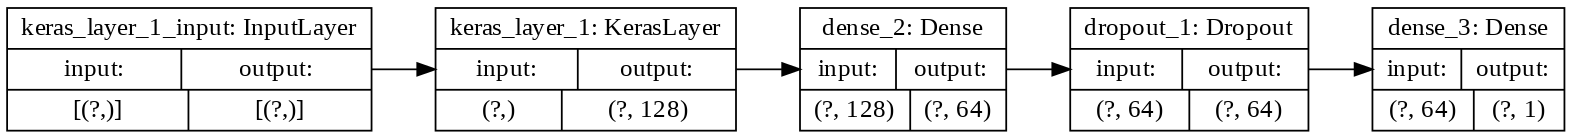

In [40]:
keras.utils.plot_model(model, 
                       #to_file='model.png',
                      show_shapes=True, show_layer_names=True, rankdir='LR', expand_nested=False, dpi=128)

## Execute Model

In [41]:
%%time
hist = model.fit(X_train, 
                 y_train, 
                 epochs=10,
                 batch_size=64, 
                 validation_split=0.2,
                 verbose = 1)
# Benchmark time: 5 min per 40 epochs for 25 000 records/128 nodes/batch 128/trainable=True
# Benchmark time: 1 min per 8 epochs for 25 000 records/16 nodes/batch 128/trainable=True

Train on 20000 samples, validate on 5000 samples
Epoch 1/10
20000/20000 [==============================] - 15s 727us/sample - loss: 0.3659 - accuracy: 0.8372 - val_loss: 0.2940 - val_accuracy: 0.8730
Epoch 2/10
20000/20000 [==============================] - 14s 684us/sample - loss: 0.1321 - accuracy: 0.9544 - val_loss: 0.3583 - val_accuracy: 0.8690
Epoch 3/10
20000/20000 [==============================] - 14s 680us/sample - loss: 0.0520 - accuracy: 0.9810 - val_loss: 0.4943 - val_accuracy: 0.8650
Epoch 4/10
20000/20000 [==============================] - 14s 679us/sample - loss: 0.0318 - accuracy: 0.9887 - val_loss: 0.5885 - val_accuracy: 0.8578
Epoch 5/10
20000/20000 [==============================] - 14s 685us/sample - loss: 0.0242 - accuracy: 0.9906 - val_loss: 0.7978 - val_accuracy: 0.8622
Epoch 6/10
20000/20000 [==============================] - 14s 694us/sample - loss: 0.0188 - accuracy: 0.9933 - val_loss: 0.8382 - val_accuracy: 0.8604
Epoch 7/10
20000/20000 [=====================

<function matplotlib.pyplot.show>

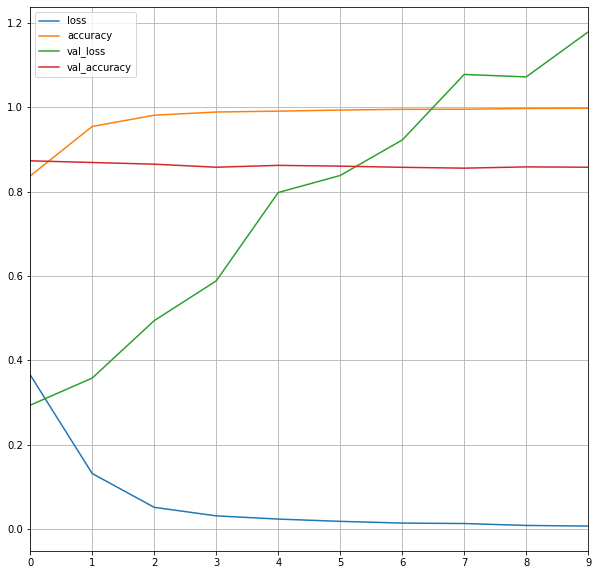

In [42]:
pd.DataFrame(hist.history).plot(figsize=(10,10))
plt.grid(True)
plt.show

## Evaluate Model

In [43]:
accuracy_test = model.evaluate(X_test, y_test, verbose=2)
print(accuracy_test)

25000/1 - 5s - loss: 1.4081 - accuracy: 0.8354
[1.3578322601771355, 0.83544]


## Some sentences to test the models

In [0]:
my_sentences = "/content/drive/My Drive/Colab Notebooks/NLP/sentences_sa.csv"
columns = ['tweet', 'polarity']

In [46]:
# Import my sentences
df_my_sentences = pd.read_csv(my_sentences,
                 header=None, 
                 names=columns, 
                 encoding='latin-1')
df_my_sentences.shape

(23, 2)

In [0]:
df_my_sentences['clean_tweet'] = df_my_sentences['tweet'].apply(lambda x: text_processing(x, preprocess=False))

In [0]:
df_my_sentences["clean_tweet"] = lemmatization(df_my_sentences["clean_tweet"])

In [48]:
df_my_sentences

,tweet,polarity,clean_tweet
0,I do not dislike cabin cruisers,4,I do not dislike cabin cruisers
1,Montreal is a nice city in the summer!!!,4,Montreal is a nice city in the summer!!!
2,I have a good feeling about this team#11212,4,I have a good feeling about this team#11212
3,The Montreal hockey team will be making the pl...,4,The Montreal hockey team will be making the pl...
4,The weather in Montreal is very nice in the su...,4,The weather in Montreal is very nice in the su...
5,Coronet has the best lines of all day cruisers,4,Coronet has the best lines of all day cruisers
6,Bertram has a deep V hull and runs easily thro...,4,Bertram has a deep V hull and runs easily thro...
7,I'd really truly love going out in this weather!,4,I'd really truly love going out in this weather!
8,Chris Craft is better looking than Limestone.,4,Chris Craft is better looking than Limestone.
9,"Chris Craft is better looking than Limestone, ...",4,"Chris Craft is better looking than Limestone, ..."


In [0]:
sentiments = df_my_sentences["polarity"].copy()
label_encoder = LabelEncoder()
sentiments = label_encoder.fit_transform(sentiments)
#sentiments = keras.utils.to_categorical(sentiments)

In [0]:
X_input = df_my_sentences["clean_tweet"].values

In [51]:
print(model.predict(X_input).round(0))

[[0.]
 [0.]
 [1.]
 [0.]
 [0.]
 [1.]
 [1.]
 [1.]
 [0.]
 [0.]
 [1.]
 [1.]
 [0.]
 [0.]
 [0.]
 [1.]
 [1.]
 [0.]
 [0.]
 [0.]
 [0.]
 [1.]
 [1.]]


In [55]:
accuracy_test = model.evaluate(X_input, sentiments, verbose=2)
print(accuracy_test)

23/1 - 0s - loss: 4.1425 - accuracy: 0.5217
[4.142542839050293, 0.5217391]


In [54]:
print(sentiments)

[1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0]


# Model Universal Sentence Encoder



## Create Model

In [0]:
MODEL = "universal-sentence-encoder"
VERSION = 4
URL = "https://tfhub.dev/google/"+MODEL+"/"+str(VERSION)
print (URL)

https://tfhub.dev/google/universal-sentence-encoder/4


In [0]:
hub_layer2 = hub.KerasLayer(URL, 
                           output_shape=[512], 
                           input_shape=[], 
                           dtype=tf.string, 
                           #trainable=True
                          )
model = keras.Sequential()
model.add(hub_layer2)
model.add(keras.layers.Dense(64, activation='relu'))
model.add(keras.layers.Dropout(0.5))
model.add(keras.layers.Dense(1, activation='sigmoid'))

model.summary()

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
keras_layer_6 (KerasLayer)   (None, 512)               256797824 
_________________________________________________________________
dense_12 (Dense)             (None, 64)                32832     
_________________________________________________________________
dropout_6 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_13 (Dense)             (None, 1)                 65        
Total params: 256,830,721
Trainable params: 32,897
Non-trainable params: 256,797,824
_________________________________________________________________


In [0]:
model.compile(loss='binary_crossentropy', optimizer=opti, metrics=['accuracy'])

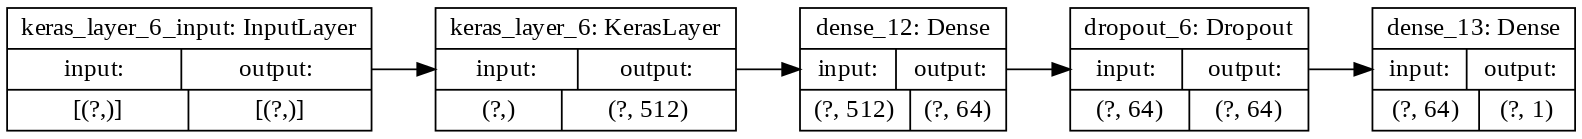

In [0]:
keras.utils.plot_model(model, 
                       #to_file='model.png',
                       show_shapes=True, show_layer_names=True, rankdir='LR', expand_nested=False, dpi=128)

## Execute Model

In [0]:
%%time
hist = model.fit(X_train, 
                 y_train, 
                 epochs=20, 
                 batch_size=128, 
                 validation_split=.2,
                 verbose = 1)
# Benchmark time: 5 min for 10 epochs/25 000 records/64 nodes/batch 128
# Benchmark time: 11 min for 20 epochs/25 000 records/64 nodes/batch 128

Train on 20000 samples, validate on 5000 samples
Epoch 1/20
20000/20000 [==============================] - 35s 2ms/sample - loss: 0.3771 - accuracy: 0.8324 - val_loss: 0.3243 - val_accuracy: 0.8714
Epoch 2/20
20000/20000 [==============================] - 33s 2ms/sample - loss: 0.3339 - accuracy: 0.8558 - val_loss: 0.3148 - val_accuracy: 0.8682
Epoch 3/20
20000/20000 [==============================] - 34s 2ms/sample - loss: 0.3261 - accuracy: 0.8606 - val_loss: 0.3148 - val_accuracy: 0.8716
Epoch 4/20
20000/20000 [==============================] - 34s 2ms/sample - loss: 0.3186 - accuracy: 0.8642 - val_loss: 0.3099 - val_accuracy: 0.8732
Epoch 5/20
20000/20000 [==============================] - 34s 2ms/sample - loss: 0.3133 - accuracy: 0.8670 - val_loss: 0.3103 - val_accuracy: 0.8748
Epoch 6/20
20000/20000 [==============================] - 34s 2ms/sample - loss: 0.3097 - accuracy: 0.8699 - val_loss: 0.3095 - val_accuracy: 0.8752
Epoch 7/20
20000/20000 [==============================] -

<function matplotlib.pyplot.show>

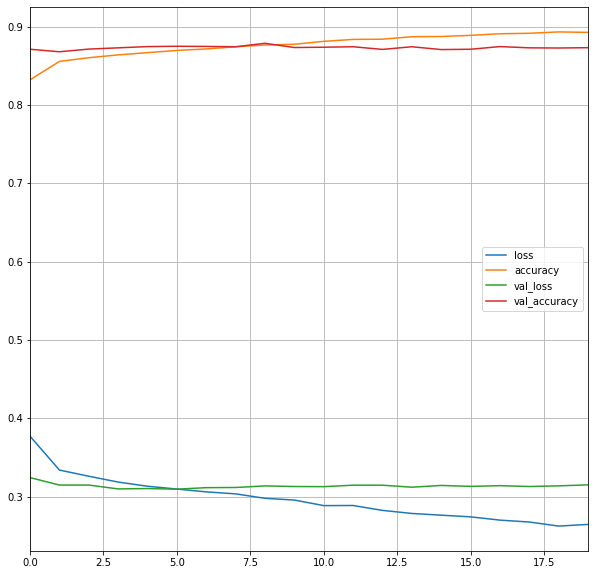

In [0]:
pd.DataFrame(hist.history).plot(figsize=(10,10))
plt.grid(True)
plt.show

## Evaluate Model Universal Sentence Encoder

In [0]:
accuracy_test = model.evaluate(X_test, y_test, verbose=2)
print(accuracy_test)

25000/1 - 35s - loss: 0.2304 - accuracy: 0.8599
[0.32338667462348936, 0.85992]


In [0]:
print(X_train[0:10])

['yaeljk get to a show girl do whatcha get to do what if this be -PRON- last tour omg i do not wanna think about -PRON-'
 'ex boyfriend suck pete the alien'
 '.spaciestaycie which one do -PRON- like good'
 'damn -PRON- back be hella hurtte at work'
 'tristanwild unfortunately -PRON- day already over'
 'nickrich i do leave , but i have to come back . n wat u tryin to say u want -PRON- to go away'
 'misspipedream oh i feel very honoured lol . i know . -PRON- be read as i type . almost finish though'
 'earn -PRON- cpr amp first aid certification'
 'yay , people be follow -PRON- exciting'
 'pworld i can not drink wine for a couple more day . -PRON- be on an antibiotic -PRON- be go to smh at someone now because of -PRON- lol']


## Test the Model with some sentences

In [0]:
X_input

NameError: ignored

In [0]:
print(model.predict(X_input).round(0))

[[0.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [0.]
 [0.]
 [0.]
 [1.]
 [0.]
 [0.]]


In [0]:
print(sentiments)

0     1
1     1
2     1
3     1
4     1
5     1
6     0
7     0
8     0
9     0
10    0
11    0
Name: sentiments, dtype: int64


In [0]:
model.predict(["The actors are really good"])

array([[0.9702056]], dtype=float32)